In [85]:
import datetime
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Basic Preprocesing

In [32]:
df_houses = pd.read_parquet("../dataset/etl/L1.houses.parquet")
df_house_tags = pd.read_parquet("../dataset/etl/L1.house_tags.parquet")
df_house_specs = pd.read_parquet("../dataset/etl/L1.house_specs.parquet")
df_house_material = pd.read_parquet("../dataset/etl/L1.house_material.parquet")
df_house_floor_material = pd.read_parquet("../dataset/etl/L1.house_floor_material.parquet")

In [33]:
df_house_specs.head()

,kamar_tidur,kamar_mandi,sertifikat,kamar_pembantu,kamar_mandi_pembantu,jumlah_lantai,tahun_dibangun,dapur,garasi,pemandangan,...,luas_tanah_num,luas_bangunan_num,daya_listrik_num,lebar_jalan_num,kondisi_properti_norm,kondisi_perabotan_norm,ruang_makan_available,ruang_tamu_available,terjangkau_internet_available,hook_available
0,3.0,3.0,SHM - Sertifikat Hak Milik,1.0,1.0,1.0,1000.0,NaN,NaN,None,...,300.0,180.0,2200.0,NaN,furnished,None,None,None,None,None
1,4.0,3.0,SHM - Sertifikat Hak Milik,4.0,1.0,1.0,2016.0,1.0,4.0,Pegunungan,...,385.0,270.0,2200.0,2.0,furnished,semi furnished,False,False,True,False
2,3.0,2.0,SHM - Sertifikat Hak Milik,NaN,NaN,2.0,2020.0,NaN,1.0,None,...,68.0,72.0,2200.0,NaN,furnished,None,None,None,None,None
3,3.0,3.0,SHM - Sertifikat Hak Milik,2.0,1.0,1.0,2013.0,NaN,3.0,None,...,1200.0,450.0,13200.0,NaN,furnished,furnished,None,None,None,None
4,4.0,4.0,"Lainnya (PPJB,Girik,Adat,dll)",NaN,NaN,NaN,NaN,NaN,NaN,None,...,300.0,400.0,0.0,NaN,None,None,None,None,None,None


In [34]:
df_house_tags_tab = pd.crosstab(df_house_tags["reference_id"], df_house_tags["tag"]).reset_index().add_prefix("tags_")
df_house_tags_tab.head()

tag,tags_reference_id,tags_bisa_nego,tags_cash_bertahap,tags_cash_keras,tags_dijual_cepat,tags_komplek,tags_kpr,tags_masuk_gang,tags_one_gate_system,tags_pedesaan,tags_perumahan,tags_pinggir_jalan
0,hos10001095,1,0,0,0,0,0,0,0,0,0,0
1,hos10005281,1,0,1,0,1,1,0,0,0,1,0
2,hos10005286,1,0,1,0,0,1,0,0,0,0,0
3,hos10018975,1,0,0,0,0,0,0,0,0,0,0
4,hos10050634,1,0,1,0,0,0,1,0,0,0,0


In [35]:
house_material_tab = pd.crosstab(df_house_material["reference_id"], df_house_material["material"]).reset_index().add_prefix("house_mat_")
house_material_tab.head()

material,house_mat_reference_id,house_mat_bata_hebel,house_mat_bata_merah,house_mat_batako,house_mat_beton
0,hos10005281,1,0,0,0
1,hos10050634,0,0,1,0
2,hos10081991,0,1,0,1
3,hos10084287,0,1,0,0
4,hos10123768,0,1,0,1


In [36]:
house_floor_material_tab = pd.crosstab(df_house_floor_material["reference_id"], df_house_floor_material["material"]).reset_index().add_prefix("floor_mat_")
house_floor_material_tab.head()

material,floor_mat_reference_id,floor_mat_granit,floor_mat_keramik,floor_mat_marmer,floor_mat_ubin,floor_mat_vinyl
0,hos10005281,1,0,0,0,0
1,hos10050634,0,1,0,0,0
2,hos10081991,0,1,1,0,0
3,hos10084287,1,1,0,0,0
4,hos10123768,0,1,1,0,0


In [56]:
# merge all the dataframes
df = df_houses.merge(df_house_specs, left_on="id", right_on="reference_id", how="left")
df = df.merge(df_house_tags_tab, left_on="reference_id", right_on="tags_reference_id", how="left")
df = df.merge(house_material_tab, left_on="reference_id", right_on="house_mat_reference_id", how="left")
df = df.merge(house_floor_material_tab, left_on="reference_id", right_on="floor_mat_reference_id", how="left")
df = df.drop(columns=["tags_reference_id", "house_mat_reference_id", "floor_mat_reference_id"])

In [57]:
# derive district and city
df["district"] = df["address"].str.split(",").str[0]
df["city"] = df["address"].str.split(",").str[1]
df = df.drop(columns=["address"])

In [58]:
df.head()

,id,price,installment,description,url,last_modified_at,scraped_at,kamar_tidur,kamar_mandi,sertifikat,...,house_mat_bata_merah,house_mat_batako,house_mat_beton,floor_mat_granit,floor_mat_keramik,floor_mat_marmer,floor_mat_ubin,floor_mat_vinyl,district,city
0,hos7134669,3300.0,14.0,Di jual rumah dengan suasana aman dan nyaman j...,https://www.rumah123.com/properti/bogor/hos713...,2024-01-18T00:00:00,2024-01-21T03:10:51.029727,3.0,3.0,SHM - Sertifikat Hak Milik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puncak,Bogor
1,hos7134732,850.0,3.0,Villa Sejuk Gadog Cipanas\nDekat Istana Cipana...,https://www.rumah123.com/properti/bogor/hos713...,2023-09-12T00:00:00,2024-01-21T03:10:55.873509,4.0,3.0,SHM - Sertifikat Hak Milik,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Cipanas,Bogor
2,hos7134830,1000.0,4.0,"DIPERUMAHAN METLAND TRANSYOGI, NYAMAN, AMAN, A...",https://www.rumah123.com/properti/bogor/hos713...,2023-08-14T00:00:00,2024-01-21T03:10:58.612809,3.0,2.0,SHM - Sertifikat Hak Milik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cileungsi,Bogor
3,hos7135635,2500.0,11.0,Villa Yang sangat Luas dan Cantik ini berada d...,https://www.rumah123.com/properti/bogor/hos713...,2023-09-24T00:00:00,2024-01-21T03:11:01.403387,3.0,3.0,SHM - Sertifikat Hak Milik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caringin,Bogor
4,hos7136060,3000.0,13.0,Cocok untuk usaha Kost\nLokasi bagus\nDekat ak...,https://www.rumah123.com/properti/bogor/hos713...,2023-11-29T00:00:00,2024-01-21T03:11:05.864234,4.0,4.0,"Lainnya (PPJB,Girik,Adat,dll)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kranggan,Bogor


In [59]:
df.columns

Index(['id', 'price', 'installment', 'description', 'url', 'last_modified_at',
       'scraped_at', 'kamar_tidur', 'kamar_mandi', 'sertifikat',
       'kamar_pembantu', 'kamar_mandi_pembantu', 'jumlah_lantai',
       'tahun_dibangun', 'dapur', 'garasi', 'pemandangan', 'carport', 'hadap',
       'sumber_air', 'tahun_di_renovasi', 'konsep_dan_gaya_rumah',
       'reference_id', 'luas_tanah_num', 'luas_bangunan_num',
       'daya_listrik_num', 'lebar_jalan_num', 'kondisi_properti_norm',
       'kondisi_perabotan_norm', 'ruang_makan_available',
       'ruang_tamu_available', 'terjangkau_internet_available',
       'hook_available', 'tags_bisa_nego', 'tags_cash_bertahap',
       'tags_cash_keras', 'tags_dijual_cepat', 'tags_komplek', 'tags_kpr',
       'tags_masuk_gang', 'tags_one_gate_system', 'tags_pedesaan',
       'tags_perumahan', 'tags_pinggir_jalan', 'house_mat_bata_hebel',
       'house_mat_bata_merah', 'house_mat_batako', 'house_mat_beton',
       'floor_mat_granit', 'floor_mat_ker

## Check for Missing Values

In [60]:
def plot_missing(dfr):
    df_missing = pd.DataFrame({
        "missing": dfr.isna().sum(),
        "percentage": dfr.isna().sum() / len(dfr)
    })
    
    fig, ax = plt.subplots(figsize=(8, 10))
    df_missing.plot.barh(y="missing", ax=ax)
    ax.bar_label(ax.containers[0], labels=[f"{x:.2%}" for x in df_missing["percentage"]])

### Handle Missing Values for House Specs

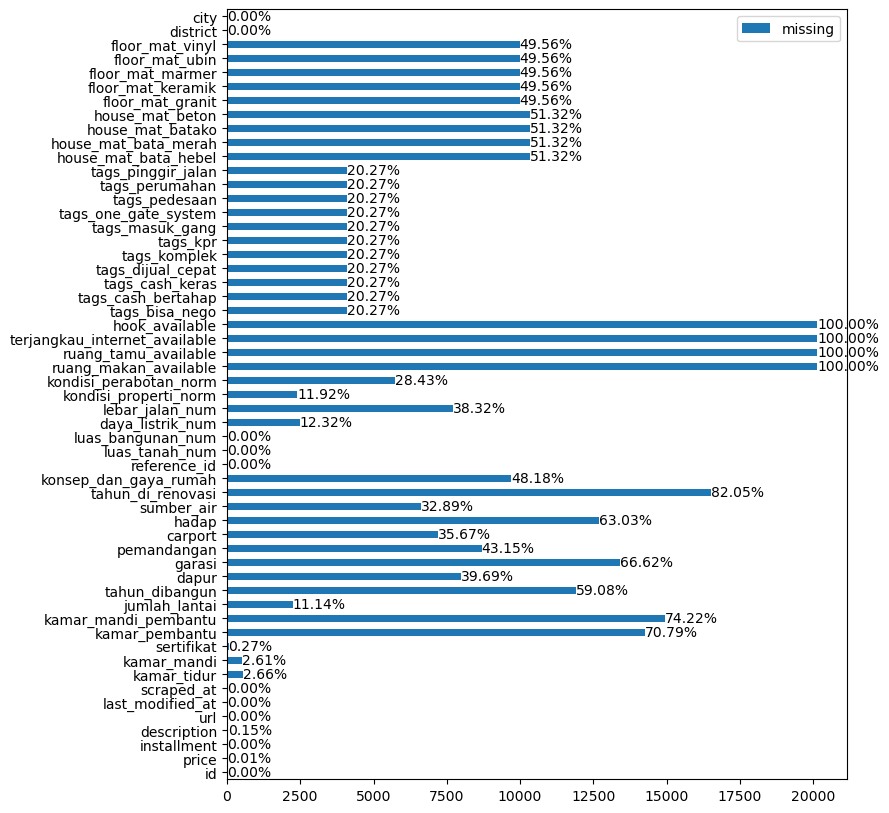

In [61]:
plot_missing(df)

In [62]:
# mode for each attributes
df.mode().iloc[0]

id                                                                     hos10001095
price                                                                       1500.0
installment                                                                    2.0
description                      Rumah sesuai dengan foto, .Bisa proses KPR, da...
url                              https://www.rumah123.com/properti/bogor/hos100...
last_modified_at                                               2024-01-19T00:00:00
scraped_at                                              2024-01-20T12:14:45.964911
kamar_tidur                                                                    2.0
kamar_mandi                                                                    1.0
sertifikat                                              SHM - Sertifikat Hak Milik
kamar_pembantu                                                                 1.0
kamar_mandi_pembantu                                                           1.0
juml

In [80]:
def clean_dataframe(dfp):
    # --- replace NaN with NA
    dfp = dfp.replace(np.nan, pd.NA)

    # --- encode boolean features
    bool_map = {False: 0, True: 1}
    dfp["hook_available"] = dfp["hook_available"].map(bool_map)
    dfp["ruang_tamu_available"] = dfp["ruang_tamu_available"].map(bool_map)
    dfp["ruang_makan_available"] = dfp["ruang_makan_available"].map(bool_map)
    dfp["terjangkau_internet_available"] = dfp["terjangkau_internet_available"].map(bool_map)

    # --- impute missing values
    # using median
    dfp["price"] = dfp["price"].fillna(dfp["price"].median())

    # using mean
    cols_fillna_mean = ["luas_tanah_num", "luas_bangunan_num"]
    for col in cols_fillna_mean:
        dfp[col] = dfp[col].fillna(dfp[col].mean())

    # using mode
    cols_fillna_mode = [
        "kondisi_perabotan_norm",
        "kondisi_properti_norm",
        "lebar_jalan_num",
        "daya_listrik_num",
        "konsep_dan_gaya_rumah",
        "sumber_air",
        "carport",
        "pemandangan",
        "sertifikat",
        "kamar_mandi",
        "kamar_tidur"
    ]

    for col in cols_fillna_mode:
        dfp[col] = dfp[col].fillna(dfp[col].mode(dropna=True).iloc[0])

    # using constant
    map_fillna_constant = { 
        "floor_mat_keramik": 1, 
        "house_mat_bata_merah": 1,
        "ruang_makan_available": 0,
        "ruang_tamu_available": 0,
        "terjangkau_internet_available": 0,
        "hook_available": 0,
        "garasi": 0,
        "dapur": 1,
        "jumlah_lantai": 1,
        "kamar_mandi_pembantu": 0,
        "kamar_pembantu": 0, 
    }

    for col, val in map_fillna_constant.items():
        dfp[col] = dfp[col].fillna(val)

    # fill constant for tags
    for col in dfp.columns:
        if col.startswith("tags_"):
            dfp[col] = dfp[col].fillna(0)
        elif col.startswith("house_mat_"):
            dfp[col] = dfp[col].fillna(0)
        elif col.startswith("floor_mat_"):
            dfp[col] = dfp[col].fillna(0)
    
    # drop column with too many missing values
    dfp = dfp.drop(columns=["id", "installment", "description", "url", "last_modified_at", "scraped_at", "hadap", "tahun_dibangun", "tahun_di_renovasi"])

    return dfp

In [81]:
df_clean = clean_dataframe(df.copy())
df_clean.head()

,price,kamar_tidur,kamar_mandi,sertifikat,kamar_pembantu,kamar_mandi_pembantu,jumlah_lantai,dapur,garasi,pemandangan,...,house_mat_bata_merah,house_mat_batako,house_mat_beton,floor_mat_granit,floor_mat_keramik,floor_mat_marmer,floor_mat_ubin,floor_mat_vinyl,district,city
0,3300.0,3.0,3.0,SHM - Sertifikat Hak Milik,1.0,1.0,1.0,1.0,0.0,Pemukiman Warga,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Puncak,Bogor
1,850.0,4.0,3.0,SHM - Sertifikat Hak Milik,4.0,1.0,1.0,1.0,4.0,Pegunungan,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Cipanas,Bogor
2,1000.0,3.0,2.0,SHM - Sertifikat Hak Milik,0.0,0.0,2.0,1.0,1.0,Pemukiman Warga,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Cileungsi,Bogor
3,2500.0,3.0,3.0,SHM - Sertifikat Hak Milik,2.0,1.0,1.0,1.0,3.0,Pemukiman Warga,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Caringin,Bogor
4,3000.0,4.0,4.0,"Lainnya (PPJB,Girik,Adat,dll)",0.0,0.0,1.0,1.0,0.0,Pemukiman Warga,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Kranggan,Bogor


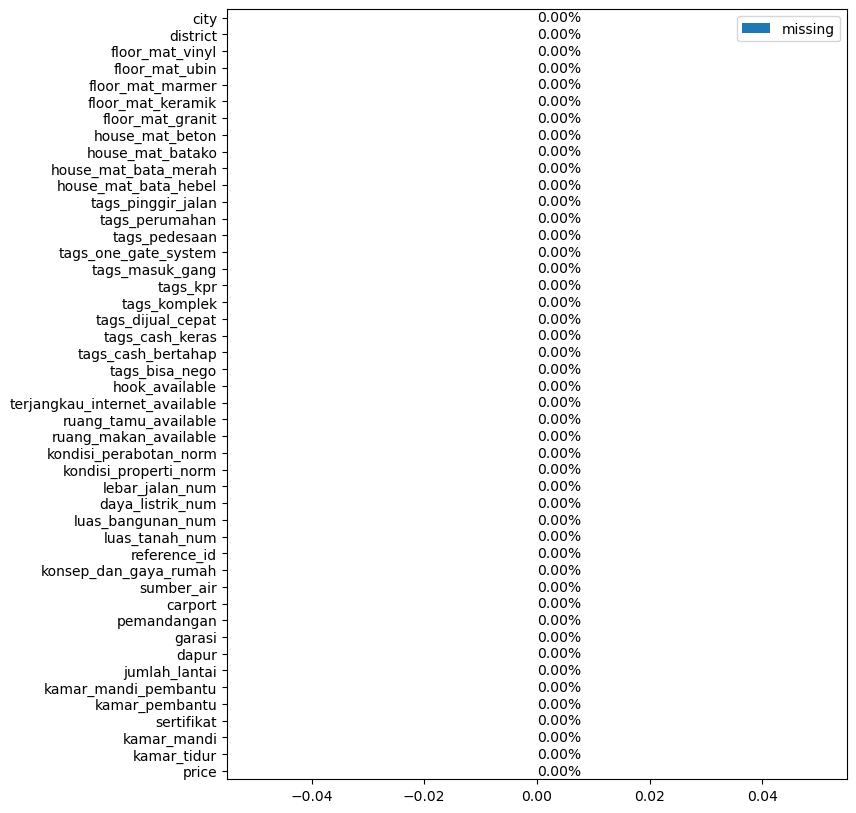

In [82]:
plot_missing(df_clean)

In [119]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20146 entries, 0 to 20145
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          20146 non-null  float64
 1   kamar_tidur                    20146 non-null  float64
 2   kamar_mandi                    20146 non-null  float64
 3   sertifikat                     20146 non-null  object 
 4   kamar_pembantu                 20146 non-null  float64
 5   kamar_mandi_pembantu           20146 non-null  float64
 6   jumlah_lantai                  20146 non-null  float64
 7   dapur                          20146 non-null  float64
 8   garasi                         20146 non-null  float64
 9   pemandangan                    20146 non-null  object 
 10  carport                        20146 non-null  float64
 11  sumber_air                     20146 non-null  object 
 12  konsep_dan_gaya_rumah          20146 non-null 

### SVD to Encode Multihot Features

In [46]:
cat_encoders = {
    "tags": TruncatedSVD(n_components=5),
    "house_mat": TruncatedSVD(n_components=4),
    "floor_mat": TruncatedSVD(n_components=4)
}

In [47]:
cat_encoders["tags"].fit_transform(df_house_tags_tab.drop(columns=["tags_reference_id"]))
cat_encoders["house_mat"].fit_transform(house_material_tab.drop(columns=["house_mat_reference_id"]))
cat_encoders["floor_mat"].fit_transform(house_floor_material_tab.drop(columns=["floor_mat_reference_id"]))

In [48]:
for name, svd in cat_encoders.items():
    print(f"{name}: {svd.explained_variance_ratio_.sum():.2%}")

tags: 88.20%
house_mat: 86.56%
floor_mat: 87.31%


In [120]:
tags_cols = [col for col in df_clean.columns if col.startswith("tags_")] + ["hook_available", "ruang_tamu_available", "ruang_makan_available", "terjangkau_internet_available"]
floor_mat_cols = [col for col in df_clean.columns if col.startswith("floor_mat_")]
house_mat_cols = [col for col in df_clean.columns if col.startswith("house_mat_")]
cat_cols = ["kondisi_perabotan_norm", "kondisi_properti_norm", "konsep_dan_gaya_rumah", "sumber_air", "pemandangan", "sertifikat"]
num_cols = ["lebar_jalan_num", "daya_listrik_num", "luas_bangunan_num", "luas_tanah_num", "carport", "garasi", "dapur", "jumlah_lantai", "kamar_mandi_pembantu", "kamar_pembantu", "kamar_mandi", "kamar_tidur"]

In [121]:
categorical_encoder = Pipeline(
  steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
  ]
)

numerical_encoder = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

compose_transformers = ColumnTransformer(
    transformers=[
        ("passthrough", "passthrough", tags_cols + floor_mat_cols + house_mat_cols),
        ("catergorical_encoder", categorical_encoder, cat_cols),
        ("numerical_encoder", numerical_encoder, num_cols),
    ]
)

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [123]:
X = df_clean.drop(columns=["price"])
y = df_clean["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [124]:
clf = Pipeline(
    steps=[
        ("preprocessor", compose_transformers),
        ("classifier", DecisionTreeRegressor()),
    ]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['tags_bisa_nego',
                                                   'tags_cash_bertahap',
                                                   'tags_cash_keras',
                                                   'tags_dijual_cepat',
                                                   'tags_komplek', 'tags_kpr',
                                                   'tags_masuk_gang',
                                                   'tags_one_gate_system',
                                                   'tags_pedesaan',
                                                   'tags_perumahan',
                                                   'tags_pinggir_jalan',
                                                   'hook_available',
                                                   'ruang_tamu_available',
                                                   'ruang_makan_availa...
                                                   'sumber_air', 'pemandangan',
                                                   'sertifikat', 'district']),
                                                 ('numerical_encoder',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lebar_jalan_num',
                                                   'daya_listrik_num',
                                                   'luas_bangunan_num',
                                                   'luas_tanah_num', 'carport',
                                                   'garasi', 'dapur',
                                                   'jumlah_lantai',
                                                   'kamar_mandi_pembantu',
                                                   'kamar_pembantu',
                                                   'kamar_mandi',
                                                   'kamar_tidur'])])),
                ('classifier', DecisionTreeRegressor())])

In [125]:
y_pred = clf.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.2%}")

MAE: 849.00
MSE: 13361593.99
MAPE: 491.08%
